# Introduction

TODO


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding, Lambda, Concatenate, Reshape
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
from keras.models import load_model
from nltk.tokenize import word_tokenize
from autocorrect import spell
import re
%matplotlib inline

Using TensorFlow backend.


# Utility functions

In [2]:
# Limit gpu allocation. allow_growth, or gpu_fraction
def gpu_alloc():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
gpu_alloc()

In [4]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]

In [5]:
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [6]:
# Artificial noisy spelling mistakes
def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0, 1, 1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0, 1, 1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i + 1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                noisy_sentence.append(random_letter)
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass
        i += 1

    return ''.join(noisy_sentence)

In [7]:
def load_data_with_gt(file_name, num_samples, max_sent_len, min_sent_len, delimiter='\t', gt_index=1, prediction_index=0):
    '''Load data from txt file, with each line has: <TXT><TAB><GT>. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    for row in open(file_name, encoding='utf8'):
        if cnt < num_samples :
            #print(row)
            sents = row.split(delimiter)
            if (len(sents) < 2):
                continue             
            input_text = sents[prediction_index]
            
            target_text = '\t' + sents[gt_index].strip() + '\n'
            if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                cnt += 1
                
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(sents[gt_index])
    return input_texts, target_texts, gt_texts

In [8]:
def load_data_with_noise(file_name, num_samples, noise_threshold, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        for row in open(file_name, encoding='utf8'):
        #for row in open(file_name):
            if cnt < num_samples :
                sents = row.split("\t")
                if (len(sents) < 2):
                    continue                 
                input_text = noise_maker(sents[1], noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sents[1].strip() + '\n'            
                if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                    cnt += 1
                    input_texts.append(input_text)
                    target_texts.append(target_text)
                    gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [9]:
def build_words_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:       
        for word in word_tokenize(sentence):
            word = process_word(word)
            if word not in vocab_to_int:
                vocab_to_int[word] = count
                count += 1


    '''''Build inverse translation from int to word'''
    int_to_vocab = {}
    for word, value in vocab_to_int.items():
        int_to_vocab[value] = word
        
    return vocab_to_int, int_to_vocab

In [10]:
def build_chars_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1


    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [11]:
def vectorize_char_data(input_texts, target_texts, max_encoder_seq_length, num_encoder_tokens, vocab_to_int):
    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length),
    dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_encoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            # c0..cn
            encoder_input_data[i, t] = vocab_to_int[char]
        for t, char in enumerate(target_text):
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t] = vocab_to_int[char]
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, vocab_to_int[char]] = 1.
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [12]:
def vectorize_hier_data(input_texts, target_texts, max_words_seq_length, max_chars_seq_length, num_char_tokens, num_word_tokens, word2int, char2int):

    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    # 
    encoder_char_input_data_lst = []
    
    decoder_word_input_data_lst = []
    
    decoder_word_target_data_lst = []

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        encoder_char_input_data = np.zeros((max_words_seq_length, max_chars_seq_length), dtype='float32')

        decoder_word_input_data = np.zeros(max_words_seq_length, dtype='float32')

        decoder_word_target_data = np.zeros((max_words_seq_length, num_word_tokens), dtype='float32')
        words_lst = word_tokenize(input_text)
        
        if(len(words_lst) > max_words_seq_length):
            continue
        for j, word in enumerate(words_lst):
            if(len(word) > max_chars_seq_length):
                continue
            for k, char in enumerate(word):
                # c0..cn
                if(char in char2int):
                    encoder_char_input_data[j, k] = char2int[char]
                    
        words_lst = word_tokenize(target_text)# word_tokenize removes the \t and \n, we need them to start and end a sequence
        words_lst.insert(0, '\t')
        words_lst.append('\n')        
        if(len(words_lst) > max_words_seq_length):
            continue                
        for j, word in enumerate(words_lst):
            #processed_word = process_word(word)
            processed_word = word
            if not processed_word in word2int:
                continue
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_word_input_data[j] = word2int[processed_word]
            if j > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_word_target_data[j - 1, word2int[processed_word]] = 1.
                
        encoder_char_input_data_lst.append(encoder_char_input_data)
    
        decoder_word_input_data_lst.append(decoder_word_input_data)
    
        decoder_word_target_data_lst.append(decoder_word_target_data)
        
    return np.array(encoder_char_input_data_lst), np.array(decoder_word_input_data_lst), np.array(decoder_word_target_data_lst)

In [13]:
def decode_gt_sequence(input_seq, int_to_vocab):

    decoded_sentence = ''
    for i in range(input_seq.shape[1]):
        
        # Sample a token
        sampled_token_index = input_seq[0][i]
        sampled_word = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_word + ' '

    return decoded_sentence

In [14]:
def decode_sequence(input_seq, encoder_model, decoder_model, max_words_seq_len, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    encoder_outputs, h, c  = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, max_words_seq_len))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_to_int['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    #print(input_seq)
    attention_density = []

    special_chars = ['\\', '/', '-', '—' , ':', '[', ']', ',', '.', '"', ';', '%', '~', '(', ')', '{', '}', '$']
    i = 0
    while not stop_condition:
        #print(target_seq)
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        #print(attention.shape)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        #print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #print(sampled_token_index)
        sampled_char = int_to_vocab[sampled_token_index]
       
        
        #orig_char = int_to_vocab[int(input_seq[:,i][0])]
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(word_tokenize(decoded_sentence)) > max_words_seq_len):
            stop_condition = True
            sampled_char = ''

        # Copy digits as it, since the spelling corrector is not good at digit corrections
        '''
        if(orig_char.isdigit() or orig_char in special_chars):
            decoded_sentence += orig_char            
        else:
            if(sampled_char.isdigit() or sampled_char in special_chars):
                decoded_sentence += ''
            else:
                decoded_sentence += sampled_char
        '''
        decoded_sentence += sampled_char + ' '


        # Update the target sequence (of length 1).
        #target_seq = np.zeros((1, max_words_seq_len))
        if i < max_words_seq_len:
            target_seq[0, i] = sampled_token_index

        # Update states
        states_value = [h, c]
        i += 1
        #if i > 48:
        #    i = 0
        

    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density


In [15]:
def decode_char_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    encoder_outputs, h, c  = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_to_int['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    #print(input_seq)
    attention_density = []
    i = 0
    special_chars = ['\\', '/', '-', '—' , ':', '[', ']', ',', '.', '"', ';', '%', '~', '(', ')', '{', '}', '$']
    while not stop_condition:
        #print(target_seq)
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        #print(attention.shape)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        #print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #print(sampled_token_index)
        sampled_char = int_to_vocab[sampled_token_index]
        orig_char = int_to_vocab[int(input_seq[:,i][0])]
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
            sampled_char = ''

        # Copy digits as it, since the spelling corrector is not good at digit corrections
        if(orig_char.isdigit() or orig_char in special_chars):
            decoded_sentence += orig_char            
        else:
            if(sampled_char.isdigit() or sampled_char in special_chars):
                decoded_sentence += ''
            else:
                decoded_sentence += sampled_char
        


        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
        
        i += 1
        if(i > 48):
            i = 0
    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density


In [16]:
def build_char_model(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(encoder_inputs)    
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    #print(encoder_states)
    
    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    #print(decoder_outputs)
    #print(encoder_outputs)
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    #print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    #print('context', context)
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)

    decoder_dense = Dense(num_encoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    #model = Model(decoder_inputs, decoder_outputs)
    #print('encoder-decoder  model:')
    print(model.summary()) 
    
    #print(encoder_inputs)
    #print(encoder_outputs)
    #print(encoder_states)
    #encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
    encoder_model = Model(input=encoder_inputs, output=[encoder_outputs] + encoder_states)
    print(encoder_outputs.shape)
    encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
    encoder_word_embedding_model = Model(input=encoder_inputs, output=encoder_embedding_output)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    #print('attention', attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    #print('context', context)
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)
    
    #decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model, encoder_word_embedding_model

In [17]:
def build_hier_model(encoder_word_embedding_model, max_words_seq_len, max_char_seq_len, num_word_tokens, num_char_tokens, latent_dim):
    # Define an input sequence and process it.

    inputs = Input(shape=(max_words_seq_len, max_char_seq_len,), dtype='float32')
    decoder_inputs_words = Input(shape=(max_words_seq_len,), dtype='float32')
    words_states = []
    '''
    for w in range(max_words_seq_len):
        
        encoder_char_inputs = Lambda(lambda x: x[:,w,:])(inputs)
        _, h, c = encoder_char_model(encoder_char_inputs)
        encoder_chars_states = Concatenate()([h,c])
        #print(encoder_chars_states)
        encoder_chars_states = Reshape((1,latent_dim*4))(encoder_chars_states)
        words_states.append(encoder_chars_states)
    
    input_words = Concatenate(axis=-2)(words_states)

    '''
    #input_words = TimeDistributed(Dense(10))(inputs)

    input_words = TimeDistributed(encoder_word_embedding_model)(inputs)

    encoder_inputs_ = input_words   
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    
    decoder_inputs = decoder_inputs_words
    decoder_inputs_ = Embedding(num_word_tokens, latent_dim*4,                           
                            #weights=[np.eye(num_word_tokens)],
                            mask_zero=True, trainable=True)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax')
    attention = att_activation(attention)
    #print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    #print('context', context)
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)

    decoder_dense = Dense(num_word_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([inputs, decoder_inputs_words], decoder_outputs)
    #model = Model(decoder_inputs, decoder_outputs)
    print('encoder-decoder  model:')
    print(model.summary()) 
    
    #encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
    encoder_model = Model(input=inputs, output=[encoder_outputs] + encoder_states)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_encoder_inputs = Input(shape=(max_words_seq_len, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    #print('attention', attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    #print('context', context)
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)
    
    #decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs_words, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model

In [18]:

def visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab):

    encoder_input_data = np.zeros((1, max_encoder_seq_length), dtype='float32')
    
    for t, char in enumerate(text):
        # c0..cn
        encoder_input_data[0, t] = vocab_to_int[char]

    input_seq = encoder_input_data[0:1]

    decoded_sentence, attention_density = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = sns.heatmap(attention_density[:, : len(text) + 2],
        xticklabels=[w for w in text],
        yticklabels=[w for w in decoded_sentence])

    ax.invert_yaxis()
    plt.show()
    
    return decoded_sentence

In [19]:
def process_word(word):
    # Try to correct the word from known dict
    #word = spell(word)
    # Option 1: Replace special chars and digits
    #processed_word = re.sub(r'[\\\/\-\—\:\[\]\,\.\"\;\%\~\(\)\{\}\$\#\?\●\@\+\-\*\d]', r'', w.lower())
    
    # Option 2: skip all words with special chars or digits
    if(len(re.findall(r'[\\\/\-\—\:\[\]\,\.\"\;\%\~\(\)\{\}\$\#\?\●\@\+\-\*\d]', word.lower())) == 0):
        #processed_word = word.lower()
        processed_word = word
    else:
        processed_word = 'UNK'

    # Skip stop words
    #stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]        
    stop_words = []
    if processed_word in stop_words:
        processed_word = 'UNK'
        
    return processed_word


# Pre-train char model

## Load data

In [20]:
data_path = '../../dat/'
max_sent_len = 50
min_sent_len = 0

In [21]:
num_samples = 1000000
input_texts = []
target_texts = []
#files_list = ['all_ocr_data_2.txt', 'field_class_21.txt', 'field_class_32.txt', 'field_class_30.txt']
files_list = ['all_ocr_data_2.txt', 'field_class_21.txt', 'field_class_22.txt', 'field_class_23.txt', 'field_class_24.txt', 'field_class_25.txt', 'field_class_26.txt', 'field_class_27.txt', 'field_class_28.txt', 'field_class_29.txt', 'field_class_30.txt', 'field_class_31.txt', 'field_class_32.txt', 'field_class_33.txt', 'field_class_34.txt', 'NL-14622714.txt', 'NL-14627449.txt', 'NL-14628986.txt', 'NL-14631911.txt', 'NL-14640007.txt']
#desired_file_sizes = [num_samples, num_samples, num_samples, num_samples]
desired_file_sizes = []
for i in range(len(files_list)):
    desired_file_sizes.append(num_samples)
noise_threshold = 0.9

for file_name, num_file_samples in zip(files_list, desired_file_sizes):
    print(file_name)
    tess_correction_data = os.path.join(data_path, file_name)
    input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_file_samples, max_sent_len, min_sent_len, delimiter='\t', gt_index=1, prediction_index=0)

    input_texts += input_texts_OCR
    target_texts += target_texts_OCR

    

all_ocr_data_2.txt
field_class_21.txt
field_class_22.txt
field_class_23.txt
field_class_24.txt
field_class_25.txt
field_class_26.txt
field_class_27.txt
field_class_28.txt
field_class_29.txt
field_class_30.txt
field_class_31.txt
field_class_32.txt
field_class_33.txt
field_class_34.txt
NL-14622714.txt
NL-14627449.txt
NL-14628986.txt
NL-14631911.txt
NL-14640007.txt


In [22]:
len(input_texts)

9150

In [23]:
# Sample data
print(len(input_texts))
for i in range(10):
    print(input_texts[i], '\n', target_texts[i])

9150
Claim Type: VB Accident - Accidental Injury 
 	Claim Type: VB Accident - Accidental Injury

Pol inyhold elm-Chm er [11 form arlon 
 	Policyholder/Owner Information

First Name: 
 	First Name:

Middle Nameﬂnitial: 
 	Middle Name/Initial:

Last Name: 
 	Last Name:

Social S ecurity Number: 
 	Social Security Number:

Birth Date: 
 	Birth Date:

Gender: 
 	Gender:

Language Preference: 
 	Language Preference:

Address Line 1: 
 	Address Line 1:



### Histogram of lenghts

In [24]:

chars_per_words_lengths = []
words_per_sents_lengths = []

# Chars per word should be on all text
for text in (input_texts_OCR+target_texts_OCR):
    words = word_tokenize(text)
    #words_per_sents_lengths.append(len(words))
    for word in words:
        chars_per_words_lengths.append(len(word))

# Words in sent should be on target only        
for text in target_texts_OCR:
    words = word_tokenize(text)
    words_per_sents_lengths.append(len(words))
    

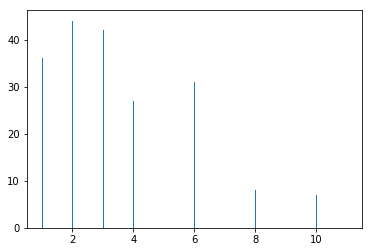

In [25]:
h_w = plt.hist(words_per_sents_lengths, bins=500)

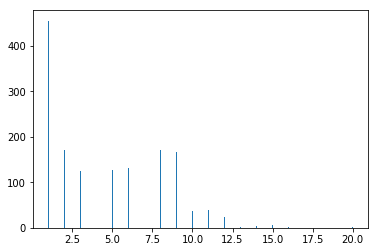

In [26]:
h_c = plt.hist(chars_per_words_lengths, bins=500)

## Build char vocab (all text)

In [27]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_chars_vocab(all_texts)
np.savez('vocab_char-{}'.format(max_sent_len), vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )
char2int = vocab_to_int
int2char = int_to_vocab

In [28]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [29]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 9150
Number of unique input tokens: 126
Number of unique output tokens: 126
Max sequence length for inputs: 49
Max sequence length for outputs: 49


In [30]:
char2int

{'\t': 2,
 '\n': 3,
 '\x0c': 120,
 ' ': 1,
 '!': 111,
 '"': 95,
 '#': 67,
 '$': 79,
 '%': 85,
 '&': 73,
 "'": 83,
 '(': 61,
 ')': 62,
 '*': 77,
 '+': 76,
 ',': 69,
 '-': 21,
 '.': 54,
 '/': 29,
 '0': 63,
 '1': 43,
 '2': 53,
 '3': 52,
 '4': 66,
 '5': 74,
 '6': 65,
 '7': 70,
 '8': 58,
 '9': 72,
 ':': 13,
 ';': 75,
 '<': 105,
 '=': 94,
 '>': 106,
 '?': 56,
 '@': 81,
 'A': 16,
 'B': 15,
 'C': 4,
 'D': 40,
 'E': 46,
 'F': 33,
 'G': 41,
 'H': 57,
 'I': 22,
 'J': 68,
 'K': 49,
 'L': 37,
 'M': 36,
 'N': 35,
 'O': 30,
 'P': 26,
 'Q': 78,
 'R': 45,
 'S': 38,
 'T': 9,
 'U': 48,
 'UNK': 0,
 'V': 14,
 'W': 50,
 'X': 80,
 'Y': 47,
 'Z': 71,
 '[': 91,
 '\\': 97,
 ']': 92,
 '^': 86,
 '_': 102,
 'a': 6,
 'b': 39,
 'c': 17,
 'd': 18,
 'e': 12,
 'f': 32,
 'g': 42,
 'h': 28,
 'i': 7,
 'j': 23,
 'k': 55,
 'l': 5,
 'm': 8,
 'n': 19,
 'o': 27,
 'p': 11,
 'q': 51,
 'r': 25,
 's': 34,
 't': 20,
 'u': 24,
 'v': 44,
 'w': 31,
 'x': 59,
 'y': 10,
 'z': 60,
 '{': 113,
 '|': 82,
 '}': 104,
 '~': 110,
 '¢': 121,
 '£

In [31]:
int2char

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'C',
 5: 'l',
 6: 'a',
 7: 'i',
 8: 'm',
 9: 'T',
 10: 'y',
 11: 'p',
 12: 'e',
 13: ':',
 14: 'V',
 15: 'B',
 16: 'A',
 17: 'c',
 18: 'd',
 19: 'n',
 20: 't',
 21: '-',
 22: 'I',
 23: 'j',
 24: 'u',
 25: 'r',
 26: 'P',
 27: 'o',
 28: 'h',
 29: '/',
 30: 'O',
 31: 'w',
 32: 'f',
 33: 'F',
 34: 's',
 35: 'N',
 36: 'M',
 37: 'L',
 38: 'S',
 39: 'b',
 40: 'D',
 41: 'G',
 42: 'g',
 43: '1',
 44: 'v',
 45: 'R',
 46: 'E',
 47: 'Y',
 48: 'U',
 49: 'K',
 50: 'W',
 51: 'q',
 52: '3',
 53: '2',
 54: '.',
 55: 'k',
 56: '?',
 57: 'H',
 58: '8',
 59: 'x',
 60: 'z',
 61: '(',
 62: ')',
 63: '0',
 64: '’',
 65: '6',
 66: '4',
 67: '#',
 68: 'J',
 69: ',',
 70: '7',
 71: 'Z',
 72: '9',
 73: '&',
 74: '5',
 75: ';',
 76: '+',
 77: '*',
 78: 'Q',
 79: '$',
 80: 'X',
 81: '@',
 82: '|',
 83: "'",
 84: '•',
 85: '%',
 86: '^',
 87: '●',
 88: 'ﬁ',
 89: '”',
 90: '°',
 91: '[',
 92: ']',
 93: '–',
 94: '=',
 95: '"',
 96: '✓',
 97: '\\',
 98: '☐',
 99: '☒',
 100:

In [32]:
len(int_to_vocab)

126

## Build char model

In [33]:
latent_dim = 512 

In [34]:
model, encoder_model, decoder_model, encoder_word_embedding_model = build_char_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 126)    15876       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, None, 1024), 2617344     embedding_1[0][0]                
__________________________________________________________________________________________________
embedding_

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`


In [35]:
encoder_word_embedding_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 126)         15876     
_________________________________________________________________
bidirectional_1 (Bidirection [(None, None, 1024), (Non 2617344   
_________________________________________________________________
lambda_1 (Lambda)            (None, 1024)              0         
Total params: 2,633,220
Trainable params: 2,617,344
Non-trainable params: 15,876
_________________________________________________________________


# Train Hierarichal model

## Build word vocab (target_texts)

In [36]:
max_words_seq_len=np.max(words_per_sents_lengths)
max_chars_seq_len=np.max(chars_per_words_lengths)
print(max_words_seq_len)
print(max_chars_seq_len)

11
20


In [37]:
# Build output vocab on correct words only
all_texts = target_texts
vocab_to_int, int_to_vocab = build_words_vocab(all_texts)
word2int = vocab_to_int
int2word = int_to_vocab
np.savez('vocab_hier-{}-{}'.format(max_words_seq_len, max_chars_seq_len), char2int=char2int, int2char=int2char, word2int=word2int, int2word=int2word, max_words_seq_len=max_words_seq_len, max_char_seq_len=max_chars_seq_len)


In [38]:
word2int

{'UNK': 0,
 ' ': 1,
 '\t': 2,
 '\n': 3,
 'Claim': 4,
 'Type': 5,
 'VB': 6,
 'Accident': 7,
 'Accidental': 8,
 'Injury': 9,
 'Information': 10,
 'First': 11,
 'Name': 12,
 'Middle': 13,
 'Last': 14,
 'Social': 15,
 'Security': 16,
 'Number': 17,
 'Birth': 18,
 'Date': 19,
 'Gender': 20,
 'Language': 21,
 'Preference': 22,
 'Address': 23,
 'Line': 24,
 'City': 25,
 'Postal': 26,
 'Code': 27,
 'Country': 28,
 'Best': 29,
 'Phone': 30,
 'to': 31,
 'be': 32,
 'Reached': 33,
 'During': 34,
 'the': 35,
 'Day': 36,
 'Email': 37,
 'RADIOLOGY': 38,
 'REPORT': 39,
 'UNKNOWN': 40,
 'Technique': 41,
 'views': 42,
 'left': 43,
 'wrist': 44,
 'FINDINGS': 45,
 'IMPRESSION': 46,
 'No': 47,
 'acute': 48,
 'osseous': 49,
 'abnormality': 50,
 'identified': 51,
 'Daytime': 52,
 'Event': 53,
 'Stopped': 54,
 'Working': 55,
 'Yes': 56,
 'Physically': 57,
 'at': 58,
 'Work': 59,
 'Hours': 60,
 'Worked': 61,
 'on': 62,
 'Scheduled': 63,
 'Missed': 64,
 'Returned': 65,
 'Related': 66,
 'Time': 67,
 'of': 68,
 '

In [39]:
int2word

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'Claim',
 5: 'Type',
 6: 'VB',
 7: 'Accident',
 8: 'Accidental',
 9: 'Injury',
 10: 'Information',
 11: 'First',
 12: 'Name',
 13: 'Middle',
 14: 'Last',
 15: 'Social',
 16: 'Security',
 17: 'Number',
 18: 'Birth',
 19: 'Date',
 20: 'Gender',
 21: 'Language',
 22: 'Preference',
 23: 'Address',
 24: 'Line',
 25: 'City',
 26: 'Postal',
 27: 'Code',
 28: 'Country',
 29: 'Best',
 30: 'Phone',
 31: 'to',
 32: 'be',
 33: 'Reached',
 34: 'During',
 35: 'the',
 36: 'Day',
 37: 'Email',
 38: 'RADIOLOGY',
 39: 'REPORT',
 40: 'UNKNOWN',
 41: 'Technique',
 42: 'views',
 43: 'left',
 44: 'wrist',
 45: 'FINDINGS',
 46: 'IMPRESSION',
 47: 'No',
 48: 'acute',
 49: 'osseous',
 50: 'abnormality',
 51: 'identified',
 52: 'Daytime',
 53: 'Event',
 54: 'Stopped',
 55: 'Working',
 56: 'Yes',
 57: 'Physically',
 58: 'at',
 59: 'Work',
 60: 'Hours',
 61: 'Worked',
 62: 'on',
 63: 'Scheduled',
 64: 'Missed',
 65: 'Returned',
 66: 'Related',
 67: 'Time',
 68: 'of',
 6

In [40]:
num_word_tokens=len(sorted(list(word2int)))
num_char_tokens=len(sorted(list(char2int)))

# Train/test split

In [41]:

# Split the data into training and testing sentences
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

## Vecotrize hierarichal data

In [42]:
encoder_char_input_data, decoder_word_input_data, decoder_word_target_data = vectorize_hier_data(input_texts, 
                                                                                                target_texts, 
                                                                                                max_words_seq_len, 
                                                                                                max_chars_seq_len, 
                                                                                                num_char_tokens, 
                                                                                                num_word_tokens, 
                                                                                                word2int, 
                                                                                                char2int)

## Build Hierarichal model

In [43]:
encoder_word_embedding_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 126)         15876     
_________________________________________________________________
bidirectional_1 (Bidirection [(None, None, 1024), (Non 2617344   
_________________________________________________________________
lambda_1 (Lambda)            (None, 1024)              0         
Total params: 2,633,220
Trainable params: 2,617,344
Non-trainable params: 15,876
_________________________________________________________________


In [44]:
model, encoder_model, decoder_model = build_hier_model(encoder_word_embedding_model=encoder_word_embedding_model, 
                              max_words_seq_len=max_words_seq_len,
                              max_char_seq_len=max_chars_seq_len,
                              num_word_tokens=num_word_tokens,
                              num_char_tokens=num_char_tokens, 
                              latent_dim=latent_dim)

encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 11, 20)       0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 11, 1024)     2633220     input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 11, 1024), ( 6295552     time_distributed_1[0][0]         
_____________________________________________________________________________________

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [45]:
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 11, 20)       0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 11, 1024)     2633220     input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 11, 1024), ( 6295552     time_distributed_1[0][0]         
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 1024)         0           bidirectional_2[0][1]            
                                                                 bidirectional_2[0][3]            
__________

In [46]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 11, 2048)     7182336     input_7[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 1024)         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 1024)         0                                            
__________________________________________________________________________________________________
lstm_4 (LS

## Fit Hierarichal model

In [47]:
batch_size = 64  # Batch size for training.
epochs = 50
lr = 0.01

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_hier_model-{}-{}.hdf5".format(max_words_seq_len,max_chars_seq_len) # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]
model.fit([encoder_char_input_data, decoder_word_input_data], decoder_word_target_data,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

Train on 6039 samples, validate on 1510 samples
Epoch 1/50
6039/6039 [==============================] - 20s 3ms/step - loss: 3.2150 - categorical_accuracy: 0.1699 - val_loss: 2.5169 - val_categorical_accuracy: 0.2454

Epoch 00001: val_categorical_accuracy improved from -inf to 0.24543, saving model to best_hier_model-11-20.hdf5


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_4/concat:0' shape=(?, 1024) dtype=float32>, <tf.Tensor 'concatenate_5/concat:0' shape=(?, 1024) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/50
6039/6039 [==============================] - 17s 3ms/step - loss: 1.8730 - categorical_accuracy: 0.3015 - val_loss: 1.9169 - val_categorical_accuracy: 0.3329

Epoch 00002: val_categorical_accuracy improved from 0.24543 to 0.33289, saving model to best_hier_model-11-20.hdf5
Epoch 3/50
6039/6039 [==============================] - 17s 3ms/step - loss: 1.2125 - categorical_accuracy: 0.3744 - val_loss: 1.7871 - val_categorical_accuracy: 0.3670

Epoch 00003: val_categorical_accuracy improved from 0.33289 to 0.36703, saving model to best_hier_model-11-20.hdf5
Epoch 4/50
6039/6039 [==============================] - 17s 3ms/step - loss: 0.8392 - categorical_accuracy: 0.4287 - val_loss: 1.7734 - val_categorical_accuracy: 0.3841

Epoch 00004: val_categorical_accuracy improved from 0.36703 to 0.38410, saving model to best_hier_model-11-20.hdf5
Epoch 5/50
6039/6039 [==============================] - 17s 3ms/step - loss: 0.6042 - categorical_accuracy: 0.4713 - val_loss: 1.7654 - val_categ

KeyboardInterrupt: 

In [49]:
idx = 50

In [50]:

decode_gt_sequence(decoder_word_input_data[idx:idx+1], int2word)

'\t ED Disposition Discharge UNK Yes \n UNK UNK UNK UNK '

In [51]:
word_tokenize(input_texts[idx])

['i', 'Ail', 'Other', 'Languages', 'Contact']

In [52]:
target_texts[idx]

'\tAll Other Languages Contact\n'

In [53]:
words_lst =  word_tokenize(target_texts[idx])
words_lst.insert(0, '\t')
words_lst.append('\n')
words_lst

['\t', 'All', 'Other', 'Languages', 'Contact', '\n']

In [54]:
decode_gt_sequence(np.argmax(decoder_word_target_data[idx:idx+1], axis=-1), int2word)

'ED Disposition Discharge UNK Yes \n UNK UNK UNK UNK UNK '

In [55]:
y = model.predict([encoder_char_input_data[idx:idx+1], decoder_word_input_data[idx-1:idx]])
y.shape
#sampled_token_index = np.argmax(y[0, -1, :])
d = np.argmax(y, axis=-1)
d.shape
decode_gt_sequence(d, int2word)

'ED systems Diagnosis Contact \n \n \n \n \n \n \n '

In [56]:
input_seq = encoder_char_input_data[idx:idx+1]
decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, max_words_seq_len, num_word_tokens, int2word)
print(decoded_sentence)

ED Departure  


In [57]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_char_input_data[seq_index: seq_index + 1]
    target_seq = np.argmax(decoder_word_target_data[seq_index: seq_index + 1], axis=-1)
    #print(target_seq)
    
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, max_words_seq_len, num_word_tokens, int2word)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: follow up with where when
GT sentence: Follow Up With: Where: When:
Decoded sentence: Follow Up With  
-
Input sentence: Trace number:
GT sentence: Trace number:
Decoded sentence: Trace number  
-
Input sentence: Last Nama Sufix First Name MI_
GT sentence: Last Name Suffix First Name MI
Decoded sentence: Last Name Suffix First Name MI  
-
Input sentence: ☐ Long Tarn Disabllity
GT sentence: ☐ Long Term Disability
Decoded sentence: ☐ Short Term Disability  
-
Input sentence: ATTENDING PHYSICIAN STATEMENT (Continued)
GT sentence: ATTENDING PHYSICIAN STATEMENT (Continued)
Decoded sentence: ATTENDING PHYSICIAN STATEMENT  
-
Input sentence: fraud statements reviewed and electronically
GT sentence: Fraud Statements Reviewed and Electronically
Decoded sentence: Fraud Statements Reviewed  
-
Input sentence: medexpress
GT sentence: MedExpress
Decoded sentence: Medications  
-
Input sentence: Account #
GT sentence: Account #
Decoded sentence: Precert Policy  
-
Input sentence: N

-
Input sentence: Participant ID:
GT sentence: Participant ID:
Decoded sentence: Printed Name  
-
Input sentence: Printed Name
GT sentence: Printed Name
Decoded sentence: Accountability Act of treatment  
-
Input sentence: Accountability Act (HIPAA) Privacy Rule.
GT sentence: Accountability Act (HIPAA) Privacy Rule.
Decoded sentence: CONTACT  
-
Input sentence: CONTACT
GT sentence: CONTACT
Decoded sentence: PHONE  
-
Input sentence: Policy #:
GT sentence: Policy #:
Decoded sentence: Provider Last Name  
-
Input sentence: - Cimhosis of the liver or Hepatitis B & C
GT sentence: - Cirrhosis of the liver or Hepatitis B & C
Decoded sentence: Medical Center  
-
Input sentence: Provider Last Name: Guy
GT sentence: Provider Last Name: Guy
Decoded sentence: policy or policies  
-
Input sentence: Myelogram: Cervical Lumbar
GT sentence: [ ] Myelogram: Cervical Lumbar
Decoded sentence: Jason R Bearden TABLET  
-
Input sentence: palicy or policies.
GT sentence: policy or policies.
Decoded sentence:

# Test

In [58]:
encoder_char_input_data, decoder_word_input_data, decoder_word_target_data = vectorize_hier_data(test_input_texts, 
                                                                                                test_target_texts, 
                                                                                                max_words_seq_len, 
                                                                                                max_chars_seq_len, 
                                                                                                num_char_tokens, 
                                                                                                num_word_tokens, 
                                                                                                word2int, 
                                                                                                char2int)

In [59]:
# Sample output from val data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_char_input_data[seq_index: seq_index + 1]
    target_seq = np.argmax(decoder_word_target_data[seq_index: seq_index + 1], axis=-1)
    #print(target_seq)
    
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, max_words_seq_len, num_word_tokens, int2word)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: follow up with where when
GT sentence: Follow Up With: Where: When:
Decoded sentence: of a communicable or  
-
Input sentence: Trace number:
GT sentence: Trace number:
Decoded sentence: Commercial Insurance Adjustment  
-
Input sentence: Last Nama Sufix First Name MI_
GT sentence: Last Name Suffix First Name MI
Decoded sentence: Height  
-
Input sentence: ☐ Long Tarn Disabllity
GT sentence: ☐ Long Term Disability
Decoded sentence: Printed by a Hospital  
-
Input sentence: ATTENDING PHYSICIAN STATEMENT (Continued)
GT sentence: ATTENDING PHYSICIAN STATEMENT (Continued)
Decoded sentence: Diplomate of the  
-
Input sentence: fraud statements reviewed and electronically
GT sentence: Fraud Statements Reviewed and Electronically
Decoded sentence: Gender  
-
Input sentence: medexpress
GT sentence: MedExpress
Decoded sentence: City State Zip  
-
Input sentence: Account #
GT sentence: Account #
Decoded sentence: PATIENT  
-
Input sentence: None available.
GT sentence: None avai

-
Input sentence: Printed Name
GT sentence: Printed Name
Decoded sentence: Reviewed history from and and FOLLOWING  
-
Input sentence: Accountability Act (HIPAA) Privacy Rule.
GT sentence: Accountability Act (HIPAA) Privacy Rule.
Decoded sentence: Main Clinic  
-
Input sentence: CONTACT
GT sentence: CONTACT
Decoded sentence: Total Monthly Premium  
-
Input sentence: Policy #:
GT sentence: Policy #:
Decoded sentence: Jeffrey Ericksen by  
-
Input sentence: - Cimhosis of the liver or Hepatitis B & C
GT sentence: - Cirrhosis of the liver or Hepatitis B & C
Decoded sentence: Patient 's Signature  
-
Input sentence: Provider Last Name: Guy
GT sentence: Provider Last Name: Guy
Decoded sentence: Date of First Visit  
-
Input sentence: Myelogram: Cervical Lumbar
GT sentence: [ ] Myelogram: Cervical Lumbar
Decoded sentence: State  
-
Input sentence: palicy or policies.
GT sentence: policy or policies.
Decoded sentence: Group Policy Rd  
-
Input sentence: Jason P, Rogers, MD {Board Eligible)
GT 